In [45]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os

import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter



In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [47]:
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

In [48]:
df = pd.read_csv("train.csv", encoding="latin-1")
test_df = pd.read_csv("test.csv", encoding="latin-1")
df = df.dropna(how="any", axis=1)# 删除df中包含任何空值的列（axis=1表示操作列，how="any"表示只要存在空值就删除）
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))# 计算每条记录的'text'列的分词后的单词数量
df.head()

,id,text,target,text_len
0,1,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,Forest fire near La Ronge Sask. Canada,1,7
2,5,All residents asked to 'shelter in place' are ...,1,22
3,6,"13,000 people receive #wildfires evacuation or...",1,9
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17


*EDA*(探索性数据分析)

In [49]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4342, 3271], dtype=int64)

In [50]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real disaster'],
    y=[balance_counts[1]],
    name='Real disaster',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

In [51]:
disaster_df = df[df['target'] == 1]['text_len'].value_counts().sort_index()
fake_df = df[df['target'] == 0]['text_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=disaster_df.index,
    y=disaster_df.values,
    name='Real disaster',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=fake_df.index,
    y=fake_df.values,
    name='Fake',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.show()

*数据预处理*

In [52]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

<>:29: SyntaxWarning:

invalid escape sequence '\['

<>:31: SyntaxWarning:

invalid escape sequence '\('

<>:35: SyntaxWarning:

invalid escape sequence '\S'

<>:39: SyntaxWarning:

invalid escape sequence '\w'

<>:29: SyntaxWarning:

invalid escape sequence '\['

<>:31: SyntaxWarning:

invalid escape sequence '\('

<>:35: SyntaxWarning:

invalid escape sequence '\S'

<>:39: SyntaxWarning:

invalid escape sequence '\w'

C:\Users\Melious\AppData\Local\Temp\ipykernel_41492\2863519922.py:29: SyntaxWarning:

invalid escape sequence '\['

C:\Users\Melious\AppData\Local\Temp\ipykernel_41492\2863519922.py:31: SyntaxWarning:

invalid escape sequence '\('

C:\Users\Melious\AppData\Local\Temp\ipykernel_41492\2863519922.py:35: SyntaxWarning:

invalid escape sequence '\S'

C:\Users\Melious\AppData\Local\Temp\ipykernel_41492\2863519922.py:39: SyntaxWarning:

invalid escape sequence '\w'



In [53]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    # 清理标点，url等
    text = clean_text(text)
    # 删除停用词，进行单词提取
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

In [66]:
test_df['text_clean'] = test_df['text'].apply(preprocess_data)

df['text_clean']= df['text'].apply(preprocess_data)
df.head()

,id,text,target,text_len,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,13,deed reason earthquak may allah forgiv us
1,4,Forest fire near La Ronge Sask. Canada,1,7,forest fire near la rong sask canada
2,5,All residents asked to 'shelter in place' are ...,1,22,resid ask shelter place notifi offic evacu she...
3,6,"13,000 people receive #wildfires evacuation or...",1,9,peopl receiv wildfir evacu order california
4,7,Just got sent this photo from Ruby #Alaska as ...,1,17,got sent photo rubi alaska smoke wildfir pour ...


*词云图*

真实灾难部分

In [55]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text_clean'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [56]:
corpus_disaster_tweets = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]#计算词频
top

[('fire', 266),
 ('bomb', 179),
 ('kill', 158),
 ('news', 132),
 ('via', 121),
 ('flood', 120),
 ('disast', 116),
 ('california', 115),
 ('crash', 110),
 ('suicid', 110)]

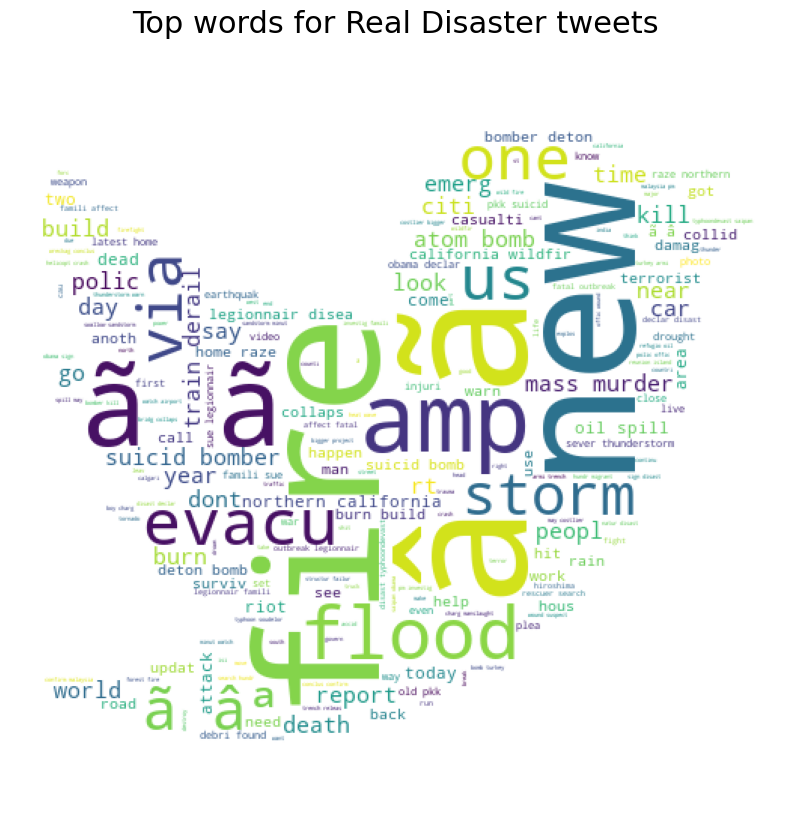

In [57]:
twitter_mask = np.array(Image.open('D:/VSCode/NLP/Program2/archive/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Real Disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

虚假灾难部分

In [58]:
corpus_disaster_tweets = create_corpus_df(df, 0)

dic=defaultdict(int)
for word in corpus_disaster_tweets:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]#计算词频
top

[('like', 306),
 ('get', 222),
 ('amp', 192),
 ('new', 168),
 ('go', 142),
 ('dont', 139),
 ('one', 134),
 ('bodi', 116),
 ('love', 115),
 ('bag', 108)]

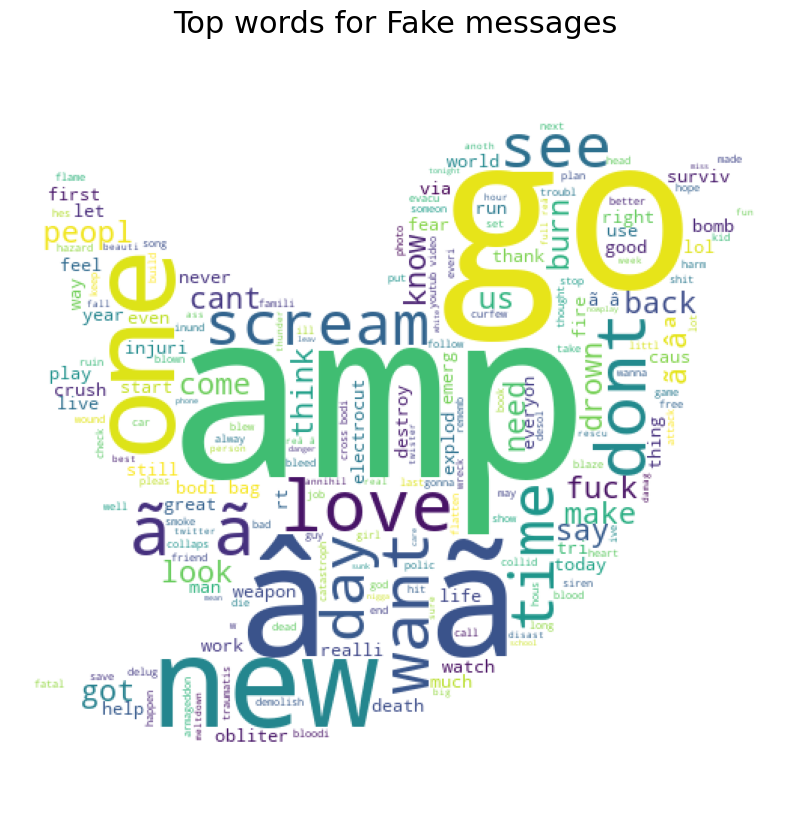

In [59]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Fake messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

*模型训练*

In [60]:
import plotly.figure_factory as ff

x_axes = ['Fake', 'Real']
y_axes =  ['Real', 'Fake']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [61]:
x = df['text_clean']
y = df['target']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5709 5709
1904 1904


In [62]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [63]:


vect = CountVectorizer()
vect.fit(x_train)

nb = MultinomialNB()

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', MultinomialNB())])

In [ ]:
pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])

# 使用数据拟合管道
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

d:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning:

[00:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




Train: 0.861096514275705
Test: 0.773109243697479


*GloVe词嵌入 - LSTM (long short-term memory)*

In [67]:
train_tweets = df['text_clean'].values
test_tweets = test_df['text_clean'].values
train_target = df['target'].values

In [68]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13704

In [69]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [70]:
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3635,  467,  201, ...,    0,    0,    0],
       [ 136,    2,  106, ...,    0,    0,    0],
       [1338,  502, 1807, ...,    0,    0,    0],
       ...,
       [ 448, 1328,    0, ...,    0,    0,    0],
       [  28,  162, 2637, ...,    0,    0,    0],
       [ 171,   31,  413, ...,    0,    0,    0]])

In [73]:
embeddings_dictionary = dict()
embedding_dim = 100
with open('D:/VSCode/NLP/Program2/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

LSTM模型

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [82]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
model = glove_lstm()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,370,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,400 (5.23 MB)

 Trainable params: 1,370,400 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5429 - loss: 0.8302
Epoch 1: val_loss improved from inf to 0.66115, saving model to model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5434 - loss: 0.8290 - val_accuracy: 0.6728 - val_loss: 0.6611 - learning_rate: 0.0010
Epoch 2/7
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6297 - loss: 0.6676
Epoch 2: val_loss improved from 0.66115 to 0.57036, saving model to model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6299 - loss: 0.6674 - val_accuracy: 0.7521 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 3/7
176/179 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7044 - loss: 0.5900
Epoch 3: val_loss improved from 0.57036 to 0.50542, saving model to model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7047 - loss: 0.5897 - val_accuracy: 0.7794 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 4/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7389 - loss: 0.5468
Epoch 4: val_loss improved from 0.50542 to 0.47695, saving model to model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7391 - loss: 0.5467 - val_accuracy: 0.7784 - val_loss: 0.4769 - learning_rate: 0.0010
Epoch 5/7
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7670 - loss: 0.5160
Epoch 5: val_loss did not improve from 0.47695
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7672 - loss: 0.5159 - val_accuracy: 0.7957 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 6/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8071 - loss: 0.4725
Epoch 6: val_loss improved from 0.47695 to 0.45015, saving model to model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8070 - loss: 0.4726 - val_accuracy: 0.8025 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 7/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8043 - loss: 0.4605
Epoch 7: val_loss improved from 0.45015 to 0.44731, saving model to model.h5


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8044 - loss: 0.4605 - val_accuracy: 0.8036 - val_loss: 0.4473 - learning_rate: 0.0010


In [84]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [85]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [87]:
pred_probs = model.predict(X_test)
preds = (pred_probs > 0.5).astype("int32")
show_metrics(preds, y_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
F1-score:  0.7413554633471646
Precision:  0.648910411622276
Recall:  0.864516129032258
Acuracy:  0.8035714285714286
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1284
           1       0.65      0.86      0.74       620

    accuracy                           0.80      1904
   macro avg       0.79      0.82      0.79      1904
weighted avg       0.83      0.80      0.81      1904

